In [8]:
import os, re, math, collections, itertools, json
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import warnings
from collections import Counter, defaultdict
import nltk
import csv 
import csv, re, warnings
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
HERE = _dh[-1]
PAPERS_OCRS = HERE / "gallica_data"  # Should be downloaded from Gallica and placed in the repo directory
OUT_DIR = HERE / "context_analysis"

In [4]:
try:
    FR_STOPWORDS = set(nltk.corpus.stopwords.words('french'))
except LookupError:
    nltk.download('stopwords')
    FR_STOPWORDS = set(nltk.corpus.stopwords.words('french'))


In [5]:

YEAR_START, YEAR_END = 1870, 1940     # years of interest

# mapping “journal title” ‑> folder‑name
repo_titles = {
      "L'Action française": "L_Action_francaise",
      "L'Aurore": "L_Aurore",
      "Le Constitutionnel": "Le_Constitutionnel",
      "La Croix": "La_Croix",
      "Figaro : journal non politique": "Le_Figaro",
      "Le Populaire": "Le_Populaire",
      "L'Humanité": "L_Humanite",
      "Le Temps": "Le_Temps",
      "Le Petit Journal": "Le_Petit_Journal",
      #"Le Petit Parisien": "Le_Petit_Parisien",
      #"La Justice": "La_Justice"
}


ANARCHIST_TOKEN_RE = re.compile(r'anarchist(?:e|es)?|anarchisme', re.IGNORECASE)

FAMILY_REGEX = {
    'anarchist': re.compile(r'anarchist(?:e|es)?|anarchisme|anarchie', re.IGNORECASE),
    'communis'  : re.compile(r'communis\w*',                   re.IGNORECASE),
    'socialis'  : re.compile(r'socialis\w*',                   re.IGNORECASE),
    'revolution': re.compile(r'r[eé]volution\w*',              re.IGNORECASE),
}

WINDOW_SIZE = 5     #number tokens for context windows
TOKEN_RE = re.compile(r'[a-zàâçéèêëîïôûùüÿñæœ]+', re.IGNORECASE)


## Words frequency per year/paper

In [7]:
for title, folder in repo_titles.items():
    paper_dir = PAPERS_OCRS / folder
    if not paper_dir.exists():
        warnings.warn(f"Missing directory: {paper_dir}")
        continue

    out_path  = HERE / "context_analysis" / f"{folder}_frequencies.csv"
    out_path.parent.mkdir(parents=True, exist_ok=True)

    with out_path.open("w", newline="", encoding="utf-8") as fout:
        writer = csv.writer(fout)
        writer.writerow([
            "paper", "year",
            "anarchist_hits", "communis_hits",
            "socialis_hits", "revolution_hits"
        ])

        for year in range(YEAR_START, YEAR_END + 1):
            year_dir = paper_dir / str(year)
            if not year_dir.exists():
                continue

            for path in year_dir.glob("*.txt"):
                try:
                    txt = path.read_text(encoding="utf-8", errors="ignore").lower()
                except Exception as e:
                    warnings.warn(f"Could not read {path}: {e}")
                    continue

                
                counts = {
                    fam: len(rx.findall(txt))
                    for fam, rx in FAMILY_REGEX.items()
                }

                writer.writerow([
                    title, year,
                    counts["anarchist"],
                    counts["communis"],
                    counts["socialis"],
                    counts["revolution"],
                ])


## What words are often present when talking about anarchism?


In [6]:
def window_tokens(tokens, w=5):
    """Yield context tokens around every anarchist hit (stop-words removed)."""
    for i, tok in enumerate(tokens):
        if ANARCHIST_TOKEN_RE.fullmatch(tok):
            left  = max(0, i - w)
            right = min(len(tokens), i + w + 1)
            for t in tokens[left:right]:
                if t != tok and t not in FR_STOPWORDS:
                    yield t

In [ ]:
global_counts       = Counter()                                
ctx_counts          = defaultdict(lambda: defaultdict(Counter))   
anarchist_hit_counts= defaultdict(lambda: defaultdict(int))       

for title, folder in repo_titles.items():
    paper_dir = PAPERS_OCRS / folder
    if not paper_dir.exists():
        warnings.warn(f"Missing directory {paper_dir}")
        continue

    for year in range(YEAR_START, YEAR_END + 1):
        year_dir = paper_dir / str(year)
        if not year_dir.exists():
            continue

        for path in year_dir.glob("*.txt"):
            try:
                txt = path.read_text(encoding="utf-8", errors="ignore").lower()
            except Exception as e:
                warnings.warn(f"Could not read {path}: {e}")
                continue

            tokens = TOKEN_RE.findall(txt)

            #total word count for the year
            global_counts.update(tokens)

            #anarchist hits frequency
            a_hits = sum(1 for t in tokens if FAMILY_REGEX['anarchist'].fullmatch(t))
            if a_hits:
                anarchist_hit_counts[title][year] += a_hits
                
                #words found in context of anarchist hits
                ctx_counts[title][year].update(window_tokens(tokens))
            

In [ ]:
N = sum(global_counts.values())

out_path = OUT_DIR / "pmi_context_words_by_paper_year.csv"
with out_path.open("w", newline="", encoding="utf-8") as fout:
    writer = csv.writer(fout)
    writer.writerow(["paper","year","word","ctx_freq","PMI"])

    for paper, year_counters in ctx_counts.items():
        for year, counter in year_counters.items():
            c_x = anarchist_hit_counts[paper][year]         
            if c_x == 0:
                continue

            for word, c_xy in counter.items():
                c_y = global_counts[word]
                if c_y < 5 or c_xy < 3:                      # skip very rare words
                    continue
                pmi = math.log2((c_xy * N) / (c_x * c_y))
                writer.writerow([paper, year, word, c_xy, round(pmi, 3)])


In [ ]:
full = pd.read_csv(OUT_DIR/"pmi_context_words_by_paper_year.csv")

#take the 10 rows with the largest PMI inside every (paper, year) group
top10 = (
    full.sort_values(["paper", "year", "PMI"], ascending=[True, True, False])
        .groupby(["paper", "year"], as_index=False)
        .head(10)               
        .reset_index(drop=True) 
)

top10.to_csv(OUT_DIR / "top10_context_words_by_paper_year.csv", index=False)

print(top10.head(20))



                             paper  year       word  ctx_freq    PMI
0   Figaro : journal non politique  1871          p         4  3.495
1   Figaro : journal non politique  1871  slategray         4  1.783
2   Figaro : journal non politique  1871      color         4  1.783
3   Figaro : journal non politique  1871       span         7  1.590
4   Figaro : journal non politique  1871      style         3  1.368
5   Figaro : journal non politique  1872  slategray         4  2.783
6   Figaro : journal non politique  1872       span         7  2.590
7   Figaro : journal non politique  1872      style         3  2.368
8   Figaro : journal non politique  1872      color         3  2.368
9   Figaro : journal non politique  1874       span         3  2.368
10  Figaro : journal non politique  1876  slategray         5  2.882
11  Figaro : journal non politique  1876       span         8  2.560
12  Figaro : journal non politique  1876      style         4  2.560
13  Figaro : journal non politique

In [19]:
df.paper.unique()

array(['Le Petit Journal'], dtype=object)

In [20]:
# get sum of each column
df.sum()

paper              Le Petit JournalLe Petit JournalLe Petit Journ...
year                                                        48094250
anarchist_hits                                                 15587
communis_hits                                                  23207
socialis_hits                                                  60969
revolution_hits                                                31535
dtype: object

## Visualization

["L'Action française"] paper              L'Action françaiseL'Action françaiseL'Action f...
year                                                        22310519
anarchist_hits                                                 16473
communis_hits                                                  44096
socialis_hits                                                  81051
revolution_hits                                                60874
dtype: object
["L'Aurore"] paper              L'AuroreL'AuroreL'AuroreL'AuroreL'AuroreL'Auro...
year                                                        11278718
anarchist_hits                                                  7194
communis_hits                                                   1631
socialis_hits                                                  67488
revolution_hits                                                28963
dtype: object
['Le Constitutionnel'] paper              Le ConstitutionnelLe ConstitutionnelLe Constit...
year            

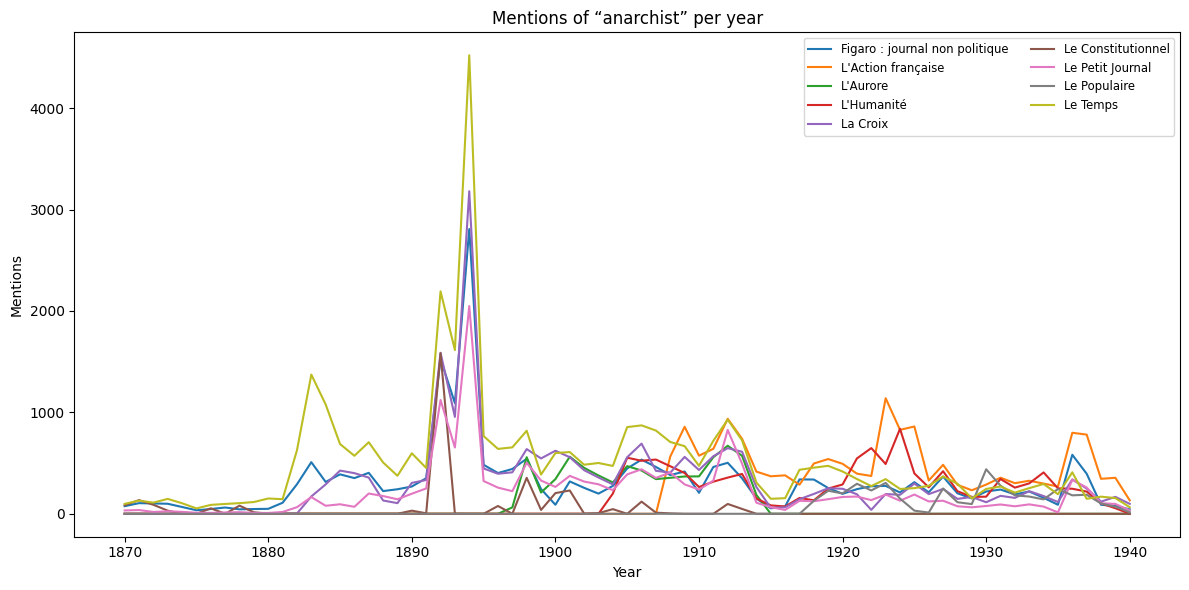

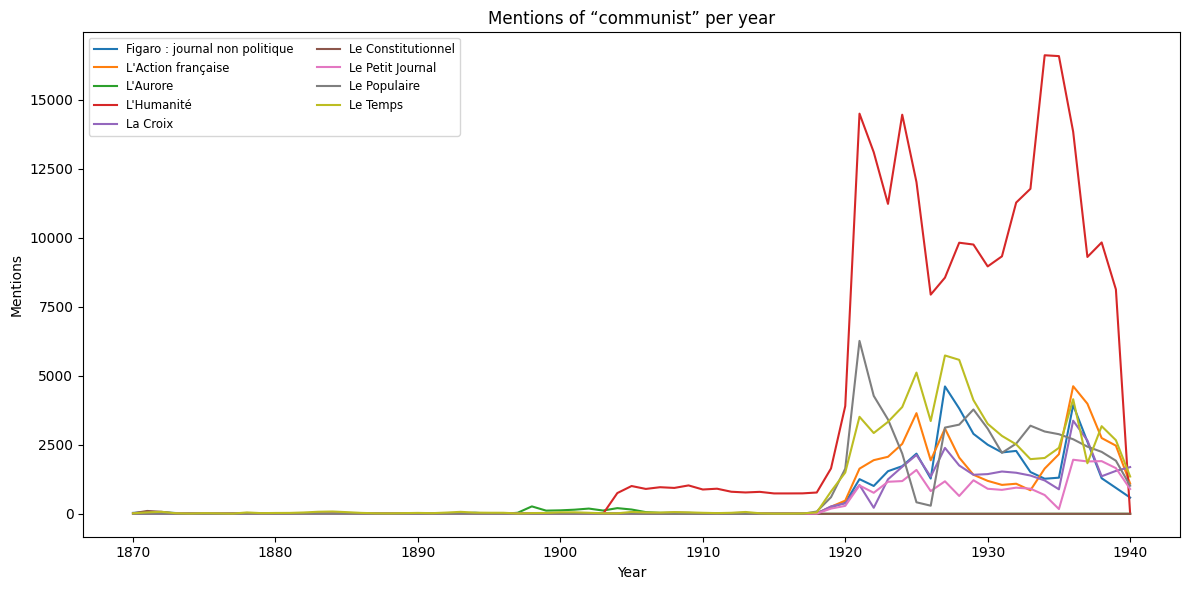

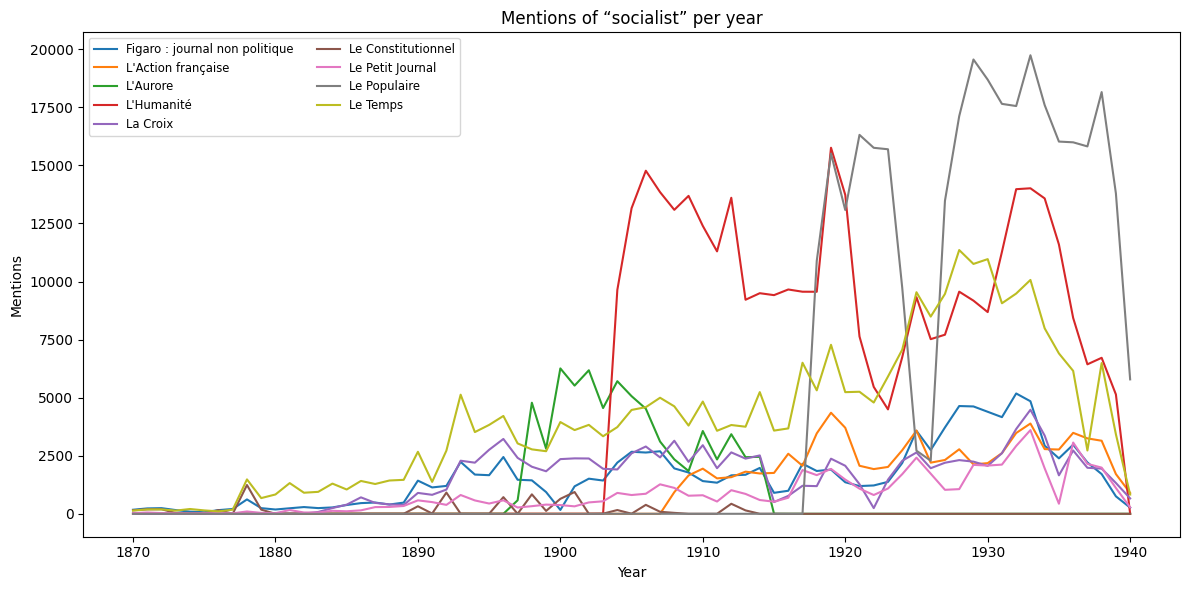

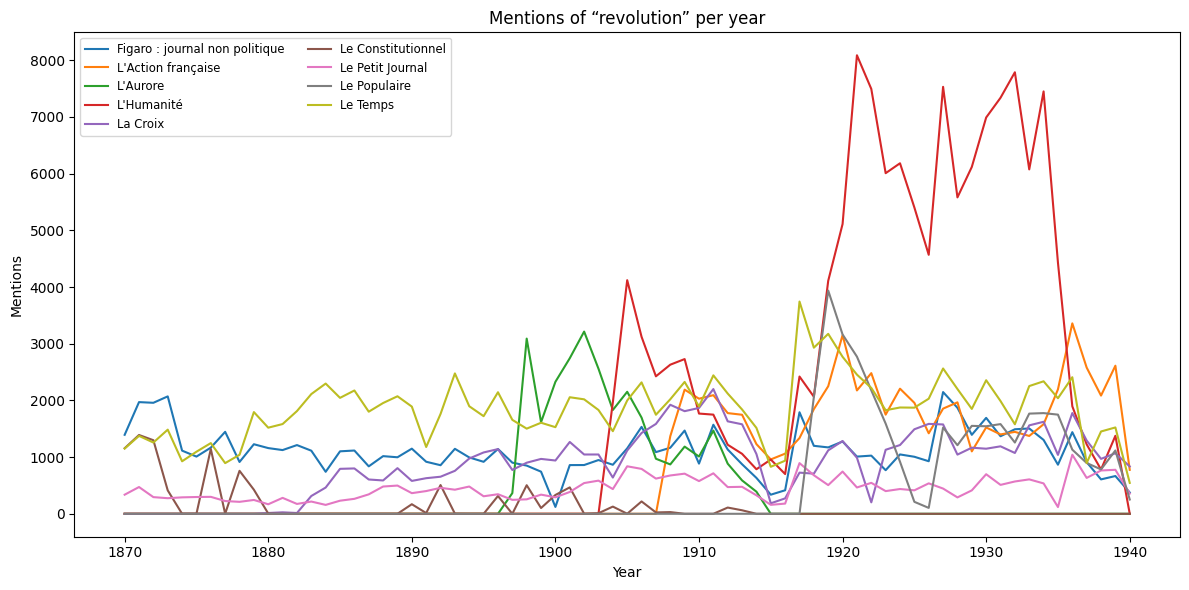

In [21]:
families = [
    ("anarchist_hits",  "anarchist"),
    ("communis_hits",   "communist"),
    ("socialis_hits",   "socialist"),
    ("revolution_hits", "revolution"),
]

# 1) Load each paper's CSV and aggregate to one row per year
frames = []
for title, folder in repo_titles.items():
    path = OUT_DIR / f"{folder}_frequencies.csv"
    if not path.exists():
        warnings.warn(f"Missing {path}")
        continue

    df = pd.read_csv(path)
    df["year"] = df["year"].astype(int)
    print(f"{df.paper.unique()}", df.sum())
    need_cols = [c for c, _ in families]
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        warnings.warn(f"{path.name} missing columns: {missing}")
        continue

    # sum counts across all issues/files in the same year
    agg = (df.groupby("year", as_index=False)[need_cols].sum())
    agg.insert(0, "paper", title)  # human-readable paper name
    frames.append(agg)

freq_all = pd.concat(frames, ignore_index=True)

# 2) Wide → long for easier filtering
long = freq_all.melt(
    id_vars=["paper", "year"],
    value_vars=[c for c, _ in families],
    var_name="family_col",
    value_name="hits",
)
name_map = {c: lab for c, lab in families}
long["family"] = long["family_col"].map(name_map)

# 3) Plot each family separately
for fam in ["anarchist", "communist", "socialist", "revolution"]:
    sub = long[long["family"] == fam]
    # pivot_table handles any remaining duplicates via aggfunc='sum'
    pivot = (
        pd.pivot_table(sub, index="year", columns="paper", values="hits", aggfunc="sum")
          .fillna(0)
          .sort_index()
    )

    plt.figure(figsize=(12, 6))
    for paper in pivot.columns:
        plt.plot(pivot.index, pivot[paper], label=paper)

    plt.title(f"Mentions of “{fam}” per year")
    plt.xlabel("Year")
    plt.ylabel("Mentions")
    plt.legend(fontsize="small", ncol=2)
    plt.tight_layout()
    plt.show()